## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
test_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2007')) | ((asos_snotel_UA_df.index >= '01-01-2017') & (asos_snotel_UA_df.index < '01-01-2018'))
train_yrs = (asos_snotel_UA_df.index >= '01-01-2007') & (asos_snotel_UA_df.index < '01-01-2017')

It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2007-2016 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [5]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps',  'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[train_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[train_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[train_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    




Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d70

In [6]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()
#test_df = asos_snotel_UA_df[good_vars_snf][test_yrs].dropna()
#train_df = asos_snotel_UA_df[good_vars_snf][train_yrs].dropna()

#print(test_df.describe())
#print(train_df.describe())
#print(filtered_asos_snotel_UA_df[train_yrs].dropna().describe())
print(asos_snotel_UA_df[good_vars_snf] ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['2014'].describe())

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', 'KGJT_d

In [7]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
test_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2007')) | ((test_train_df.index >= '01-01-2017') & (test_train_df.index< '01-01-2018'))
train_yrs_tt = (test_train_df.index >= '01-01-2007') & (test_train_df.index < '01-01-2017')



### Now run OLS model with the chosen variables ##

In [8]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', 'KGJT_d

KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m
0.09556240760614543
KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400

KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m
0.0722080913342319
KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height

LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_heigh

KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tm

CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250

KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200

KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pr

KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ 

KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_40

KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_

KGJT_d500_300_speed_kts+ KGJT_d300_200_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ K

KGJT_d500_250_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_

**Create plot of adjusted R squared**

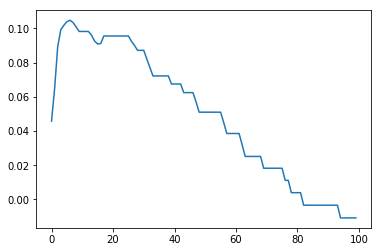

In [9]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

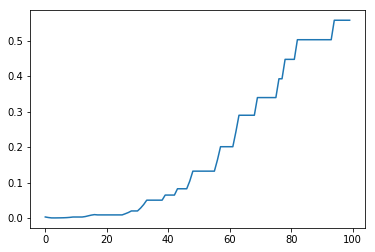

In [10]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [11]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 KGJT_d500_400_height_m 
 Adjusted R: 0.04577637218702468  Fstat(prob): 0.0029424595450004082

1 CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.06487739641306434  Fstat(prob): 0.0013671300559319319

2 KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.0892018982971794  Fstat(prob): 0.00034057320736232815

3 KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.09919631472682566  Fstat(prob): 0.0002740835477874716

4 KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.1018145429696754  Fstat(prob): 0.00037872745241418053

5 CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.10394284409549481  Fstat(prob): 0.0005072761910282134

6 KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500


25 KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.09556240760614032  Fstat(prob): 0.008764765596635063

26 KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts

38 KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 
 Adjusted R: 0.072208091334233  Fstat(prob): 0.05031369627480131

39 KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_

47 LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250_tmpc+ LXV_Dewpoint_degC+ KGJT_d400_300_speed_kts+ KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_he

55 KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_500mb_tmpc+ KGJT_d700_400_height_m+ CMtn_Temperature_degC+ KGJT_d700_400_dwpc+ KGJT_200mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d250_200_tmpc+ KGJT_d400_250

63 KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d700_400_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_500_height_m+ KGJT_700mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d500_400_tmpc+ KGJT_d500_250_tmpc+ KGJT_d

69 KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_250_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_400mb_height_m+ KGJT_500mb_height_m+ KGJT_700mb_height_m+ LXV_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_d


76 KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d700_300

81 KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_tmp

86 KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_300mb_spe

91 KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ LXV_Temperature_degC+ KGJT_700mb_spe

95 KGJT_d500_200_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_height_m+ KGJT_d400_300_height_m+ KGJT_250mb_height_m+ KGJT_d700_300_height_m+ KGJT_d500_300_height_

99 KGJT_d700_500_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d500_250_dwpc+ KGJT_d700_500_dwpc+ KGJT_700mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_300_dwpc+ KGJT_d500_400_dwpc+ KGJT_250mb_dwpc+ KGJT_d700_250_dwpc+ KGJT_d400_250_dwpc+ KGJT_d700_200_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d850_250_height_m+ KGJT_d850_200_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d850_700_height_m+ KGJT_200mb_height_m+ KGJT_d300_200_height_m+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d400_200_height_m+ KGJT_d700_200_height_m+ CMtnSNTL_Temp_degC+ KGJT_d400_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d700_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d700_250_height_m+ KGJT_300mb_hei

**Find max adj R and obtain OLS summary**

In [12]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m


In [13]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , test_train_df[train_yrs_tt]).fit() 
print(maxOLS_all.summary())


KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.142
Model:                                               OLS   Adj. R-squared:                  0.105
Method:                                    Least Squares   F-statistic:                     3.825
Date:                                   Sat, 13 Apr 2019   Prob (F-statistic):           0.000711
Time:                                           22:33:35   Log-Likelihood:                -346.67
No. Observations:                                    170   AIC:                             709.3
Df Residuals:                                        162   BIC:                             734.4
Df Model:                                              7                  

**Print QQ plot**

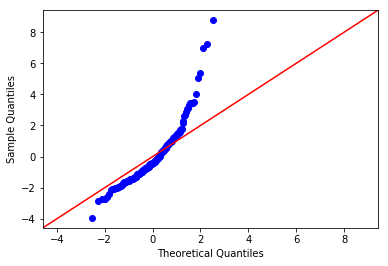

In [14]:
qq2=sm.qqplot(maxOLS_all.resid, line='45')

**There are a few variables with P|t| values which are high, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [15]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str,test_train_df[train_yrs_tt]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str,test_train_df[train_yrs_tt]).fit() 
print(maxOLS_goodp.summary())


KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m
1
KGJT_250mb_speed_kts+ KGJT_d400_200_tmpc+ KGJT_d500_400_height_m 0.06733981573007475 0.01
0.06733981573007475 0.01
2
KGJT_250mb_speed_kts+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.08656406190099553 0.02
0.08656406190099553 0.02
3
KGJT_250mb_speed_kts+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.08656406190099553 0.03
4
KGJT_250mb_speed_kts+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.08656406190099553 0.04
5
KGJT_250mb_speed_kts+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.08656406190099553 0.05
6
KGJT_250mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.09624775910562222 0.06
0.09624775910562222 0.06
7
KGJT_250mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.09

KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.10476952636880565 0.52
53
KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.10476952636880565 0.53
54
KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.10476952636880565 0.54
55
KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.10476952636880565 0.55
56
KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.10476952636880565 0.56
57
KGJT_250mb_speed_kts+ CMtn_Dewpoint_degC+ KGJT_250mb_tmpc+ KGJT_d250_200_dwpc+ KGJT_d400_200_tmpc+ CMtn_WindSpeed_mps+ KGJT_d500_400_height_m 0.104769

**No improvement to P|t| could be made**

## Try fit parameters with test dataset (2016 and 2017 data)

count    43.000000
mean      4.930233
std       2.693867
min       3.000000
25%       3.000000
50%       4.000000
75%       5.500000
max      16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64
count    43.000000
mean      4.671921
std       1.035154
min       2.721327
25%       3.966095
50%       4.732236
75%       5.352256
max       7.735371
dtype: float64
43


Text(0.5,1,'Predicted vs Actual Snowfall Amounts')

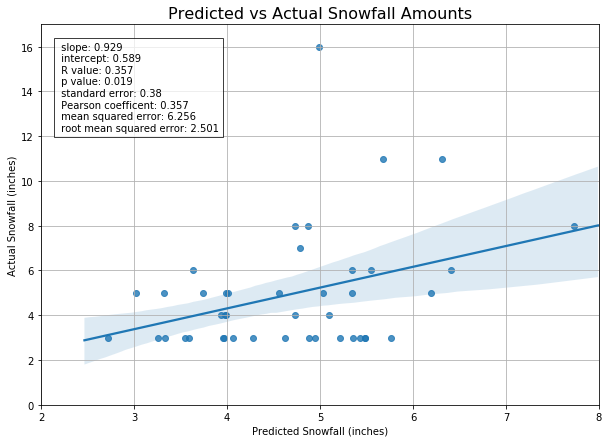

In [16]:
fig = plt.figure(figsize=(10,7))



#Define actual and predicted snowfall dataframes
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(test_train_df[test_yrs_tt][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
print(actual_snf.describe())
print(predict.describe())


#Do linear regression and calcuate relevent stats

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
print(len(idx))

#print(test_train_df[test_yrs_tt][test_train_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())


## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
#Calculate mse and rmse
mse = mean_squared_error(actual_snf[idx].values,predict[idx].values)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])

#plot and annotate
sns.regplot(predict[idx].values, actual_snf[idx].values)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([2,8])
plt.ylim([0,17])
plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/pred_vs_act_UASFC_1617.png',bbox_inches='tight')
plt.title('Predicted vs Actual Snowfall Amounts', fontsize = 16)





[4.55435613 3.31807125 3.97448139 3.01727657 4.78870155 4.73223555
 4.06400799 3.99219346 4.72815908 5.34385919 4.86802847 5.76879132
 5.55410763 5.68212844 3.54542278 6.4117007  3.33484526 4.27664406
 3.9364918  3.25976199 3.74639054 4.01201546 5.03259619 5.3411477
 3.5953404  5.42950627 4.87878064 5.48502468 5.0933751  5.48325365
 3.96979262 2.72132741 5.36065234 5.2155381  6.19169466 3.96239706
 4.99270194 3.6318686  6.30792323 4.94446725 7.7353707  4.62303671
 3.9871264 ]
[ 5.  5.  4.  5.  7.  4.  3.  4.  8.  5.  8.  3.  6. 11.  3.  6.  3.  3.
  4.  3.  5.  5.  5.  6.  3.  3.  3.  3.  4.  3.  3.  3.  3.  3.  5.  3.
 16.  6. 11.  3.  8.  3.  5.]


Text(0.5,1,'Predicted Snowfall Amounts vs Residuals')

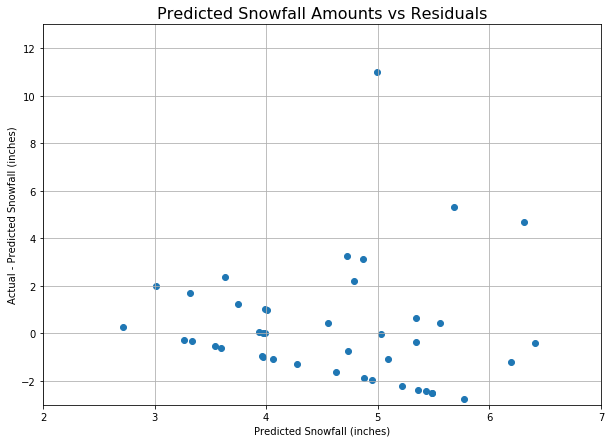

In [17]:
fig = plt.figure(figsize=(10,7))

plt.scatter(predict[idx].values, actual_snf[idx].values-predict[idx].values)
print(predict[idx].values)
print(actual_snf[idx].values)
#print(actual_snf[idx].values-predict[idx].values)

plt.ylabel('Actual - Predicted Snowfall (inches)')
plt.xlabel('Predicted Snowfall (inches)')
plt.xlim([2,7])
plt.ylim([-3,13])
plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/resid_vs_pred_UASFC_1617.png',bbox_inches='tight')
plt.title('Predicted Snowfall Amounts vs Residuals', fontsize = 16)



Text(0.5,1,'Theoretical vs Sample Quantiles of Residuals')

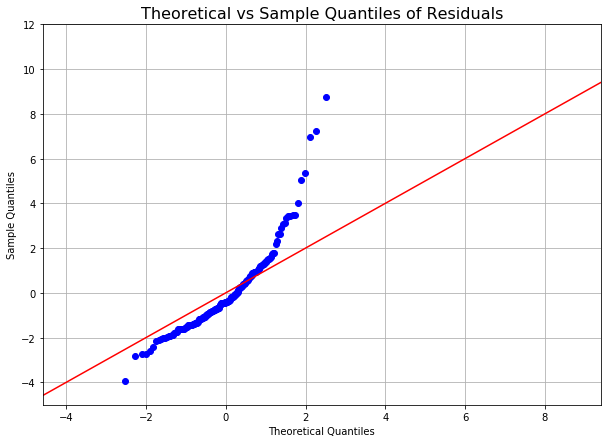

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot( maxOLS_testgoodp.resid, line='45', ax = ax)
plt.ylim([-5,12])

plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/qq_resid_UASFC_1617.png',bbox_inches='tight')
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)

Text(0.5,1,'Histogram of Residuals')

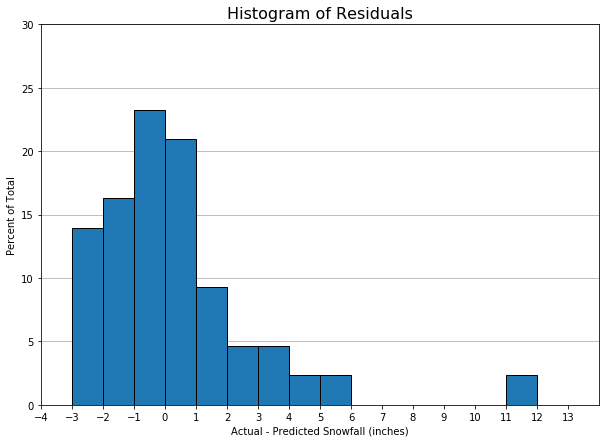

In [19]:

diff = actual_snf[idx].values-predict[idx].values
diff_df = pd.DataFrame(diff)
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(1,1,1)

#plt.hist(diff, bins = np.arange(-4,14,0.5), histtype = 'bar')
weights = np.ones_like(diff)/float(len(diff))
plt.hist(diff, histtype = 'bar', weights=weights*100, \
           bins = np.arange(-4,14,1), align = 'mid', edgecolor = 'black') 

plt.xlabel('Actual - Predicted Snowfall (inches)')
plt.ylabel('Percent of Total')
plt.xlim([-4,14])
#plt.ylim([0,10])
#plt.grid(True)

plt.xticks(np.arange(-4,14,1))
plt.yticks(np.arange(0,31,5))
ax.set_axisbelow(True)   #places gridlines behind bars
plt.grid(True, axis = 'y')
plt.title('')

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/hist_actual_minus_pred_UASFC_1617_noWD.png',bbox_inches='tight')
plt.title('Histogram of Residuals', fontsize = 16)
